 # Скрытая марковская модель


In [ ]:

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


Предположим, вы хотите смоделировать будущую вероятность того, что ваша собака находится в одном из трех состояний, учитывая ее текущее состояние. Для этого нам нужно указать пространство состояний, начальные вероятности и вероятности перехода.

Представьте, что у вас очень ленивая толстая собака, поэтому мы определяем пространство состояний как сон, еда или какашки. Мы установим начальные вероятности 35%, 35% и 30% соответственно.

In [81]:
# create state space and initial state probabilities

states = ['sleeping', 'eating', 'pip']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pip         0.30
Name: states, dtype: float64
1.0


Следующим шагом является определение вероятностей перехода. Это просто вероятность того, что вы останетесь в том же состоянии или перейдете в другое состояние, учитывая текущее состояние. 

In [83]:
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, .3]

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

         sleeping eating  pip
sleeping      0.4    0.2  0.4
eating       0.45   0.45  0.1
pip          0.45   0.25  0.3

 [[0.4 0.2 0.4]
 [0.45 0.45 0.1]
 [0.45 0.25 0.3]] (3, 3) 

sleeping    1.0
eating      1.0
pip         1.0
dtype: float64


Теперь, когда мы настроили начальную и переходную вероятности, мы можем создать диаграмму Маркова с помощью  пакета Networkx .

 Networkx создает графики,  которые состоят из узлов и ребер . В нашем игрушечном примере возможные состояния собаки - это узлы, а края - это линии, соединяющие узлы. Вероятности перехода являются весами. Они представляют вероятность перехода в состояние с учетом текущего состояния.

Следует отметить, что networkx в основном работает со словарными объектами. С учетом сказанного нам нужно создать объект словаря, который будет содержать наши ребра и их веса.

In [84]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('eating', 'eating'): 0.45,
 ('eating', 'pip'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pip', 'eating'): 0.25,
 ('pip', 'pip'): 0.3,
 ('pip', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pip'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


Теперь мы можем создать график. Для визуализации марковской модели нам нужно использовать nx.MultiDiGraph (). Multidigraph просто ориентированный граф , который может иметь множество дуг , таким образом, что один узел может быть как происхождение и назначение. 

В следующем коде мы создаем объект графа, добавляем наши узлы, ребра и метки, затем рисуем неверный график networkx при выводе нашего графа в точечный файл. 

Nodes:
['sleeping', 'eating', 'Walk']

Edges:
OutMultiEdgeDataView([('sleeping', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sleeping', 'eating', {'weight': 0.2, 'label': 0.2}), ('sleeping', 'Walk', {'weight': 0.4, 'label': 0.4}), ('eating', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('eating', 'eating', {'weight': 0.45, 'label': 0.45}), ('eating', 'Walk', {'weight': 0.1, 'label': 0.1}), ('Walk', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('Walk', 'eating', {'weight': 0.25, 'label': 0.25}), ('Walk', 'Walk', {'weight': 0.3, 'label': 0.3})])


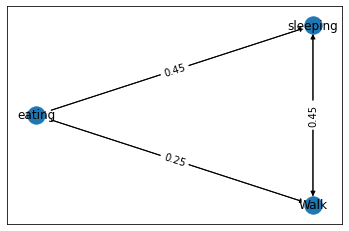

In [65]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov2.dot')

In [66]:
import pydot
(graph,) = pydot.graph_from_dot_file('pet_dog_markov2.dot')



In [85]:
graph.write_png('pet_dog_markov2.png')

Рассмотрим ситуацию, когда ваша собака ведет себя странно, и вы хотели смоделировать вероятность того, что поведение вашей собаки вызвано болезнью или просто странным поведением, когда в остальном она здорова.

В этой ситуации истинное состояние собаки неизвестно , поэтому скрыто  от вас. Один из способов смоделировать это - предположить,  что у собаки наблюдаемое  поведение, которое представляет истинное, скрытое состояние. Давайте пройдемся по примеру.

Сначала мы создаем наше множество вероятностей состояний - здоровое или больное. Мы предполагаем, что они равновероятны.  

In [86]:
# create state space and initial state probabilities

hidden_states = ['healthy', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

healthy    0.5
sick       0.5
Name: states, dtype: float64

 1.0


Далее мы создаем нашу матрицу перехода для скрытых состояний

In [87]:
# create hidden transition matrix
# a or alpha 
#   = transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

print(a_df)

a = a_df.values
print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

        healthy sick
healthy     0.7  0.3
sick        0.4  0.6

 [[0.7 0.3]
 [0.4 0.6]] (2, 2) 

healthy    1.0
sick       1.0
dtype: float64


Теперь мы создаем  матрицу вероятностей повяления наблюдений(эмиссионная матрица) . Эта матрица имеет размер M x O, где M - количество скрытых состояний, а O - количество возможных наблюдаемых состояний. 

Матрица  сообщает нам вероятность того, что собака находится в одном из скрытых состояний, учитывая текущее наблюдаемое состояние. 

Давайте сохраним те же наблюдаемые состояния из предыдущего примера. Собака может спать, есть или заниматься своими делами. Пока мы делаем лучшее предположение, чтобы заполнить вероятности. 

In [88]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

        sleeping eating  pip
healthy      0.2    0.6  0.2
sick         0.4    0.1  0.5

 [[0.2 0.6 0.2]
 [0.4 0.1 0.5]] (2, 3) 

healthy    1.0
sick       1.0
dtype: float64


Теперь мы создаем ребра графа и объект графа.

In [71]:
# create graph edges and weights

hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('healthy', 'healthy'): 0.7,
 ('healthy', 'sick'): 0.3,
 ('sick', 'healthy'): 0.4,
 ('sick', 'sick'): 0.6}
{('healthy', 'Walk'): 0.2,
 ('healthy', 'eating'): 0.6,
 ('healthy', 'sleeping'): 0.2,
 ('sick', 'Walk'): 0.5,
 ('sick', 'eating'): 0.1,
 ('sick', 'sleeping'): 0.4}


Nodes:
['healthy', 'sick']

Edges:
OutMultiEdgeDataView([('healthy', 'healthy', {'weight': 0.7, 'label': 0.7}), ('healthy', 'sick', {'weight': 0.3, 'label': 0.3}), ('healthy', 'sleeping', {'weight': 0.2, 'label': 0.2}), ('healthy', 'eating', {'weight': 0.6, 'label': 0.6}), ('healthy', 'Walk', {'weight': 0.2, 'label': 0.2}), ('sick', 'healthy', {'weight': 0.4, 'label': 0.4}), ('sick', 'sick', {'weight': 0.6, 'label': 0.6}), ('sick', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sick', 'eating', {'weight': 0.1, 'label': 0.1}), ('sick', 'Walk', {'weight': 0.5, 'label': 0.5})])


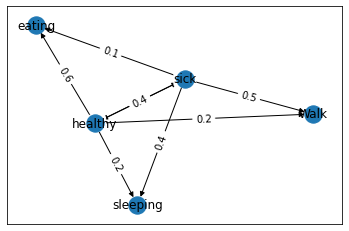

In [90]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')

In [94]:
from sklearn.tree import export_graphviz
import pydot 
(graph, ) = pydot.graph_from_dot_file('pet_dog_hidden_markov.dot')



In [95]:
graph.write_png('pet_dog_hidden_markov.png')

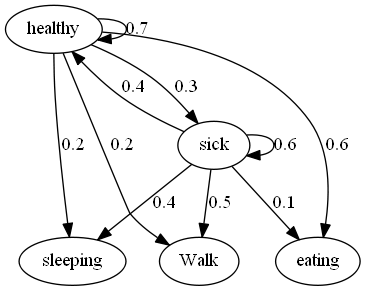

In [96]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'pet_dog_hidden_markov.png')

Скрытый марковский граф немного сложнее, но принципы те же. Например, вы ожидаете, что если ваша собака ест, есть высокая вероятность того, что она здорова (60%) и очень низкая вероятность того, что собака больна (10%).

Если необходимо со временем наблюдать за состоянием здоровья вашей собаки, учитывая последовательность наблюдений?  

In [97]:
# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


Используя  алгоритм Витерби , мы можем определить наиболее вероятную последовательность скрытых состояний с учетом последовательности наших наблюдений.

Алгоритм Витерби увеличивается с каждым шагом по времени, находя максимальную  вероятность любого пути, который попадает в состояние i в момент времени t , который также  имеет правильные наблюдения для последовательности вплоть до момента времени t .

Алгоритм также отслеживает состояние с наибольшей вероятностью на каждом этапе. В конце последовательности алгоритм будет выполнять итерацию в обратном направлении, выбирая состояние, которое «выиграло» на каждом временном шаге, и, таким образом, создавая наиболее вероятный путь или вероятную последовательность скрытых состояний, которые привели к последовательности наблюден

In [104]:
# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    path = np.zeros(T,dtype=int)
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[path[t+1], [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi



In [105]:
path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 1.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 1.0
s=0 and t=10: phi[0, 10] = 1.0
s=1 and t=10: phi[1, 10] = 1.0
s=0 and t=11: phi[0, 11] = 1.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 1.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 0.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------
Start Backtrace

path[13] = 0
path[12] = 0
path[11] = 1
path[10] = 1
path[9] = 1
path[8] = 1
pat

In [106]:
state_map = {0:'healthy', 1:'sick'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

,Observation,Best_Path
0,eating,healthy
1,eating,healthy
2,pooping,healthy
3,eating,healthy
4,sleeping,healthy
5,eating,healthy
6,pooping,healthy
7,eating,healthy
8,sleeping,sick
9,pooping,sick


In [ ]:
https://video.sas.com/detail/video/5687278647001/using-sas%C2%AE-econometrics-to-fit-gaussian-hidden-markov-models 